In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from data.ffs.readParameters import readParametersFromFileName
from ffsInference import ffsInference
parameterDef = {'name': str, 're': float, 'Lo': float, 'Ho': float}
from upt.datasets.ffs_dataset import ffsDataset


In [15]:
from upt.datasets.ffs_dataset import ffsDataset

# crop_values= [[-6, -2], [12, 2]]
crop_values= [[-2, -2], [4, 2]]

xMin = crop_values[0][0]
xMax = crop_values[0][1]

test_hr_dataset = ffsDataset(
    root="./data/ffs/preprocessedSST",
    # root="./data/ffs/preprocessed600",
    # how many inputs to use for training
    num_inputs=float("inf"),
    # num_inputs=10000,
    # how many outputs to use for training
    num_outputs=float("inf"),
    # num_outputs=10000,
    mode="test",
    crop_values=crop_values,
    useMesh=None,
    use_inferencer_inputs=False
)
from torch.utils.data import DataLoader
from upt.collators.ffs_collator import ffsCollator

# get test sample
test_dataloader = DataLoader(
    dataset=test_hr_dataset,
    batch_size=1,
    collate_fn=ffsCollator(num_supernodes=1024, deterministic=True),
)
# data = [d for d in test_dataloader]

In [16]:
# batch = data[0]

idx = 0
batch = test_dataloader.__iter__().__next__()
for i in range(idx):
    batch = batch.__next__()

input_pos = test_hr_dataset.denormalize_pos(batch['input_pos'])
input_feat = test_hr_dataset.denormalize_sdf(batch['input_feat'])
output_pos = test_hr_dataset.denormalize_pos(batch['output_pos'][0])
target_feat = test_hr_dataset.denormalize_feat(batch['target_feat'])
re = test_hr_dataset.denormalize_re(batch['re'])
parameterDict = readParametersFromFileName(batch['name'][0], parameterDef)
re = parameterDict['re']
Lo = parameterDict['Lo']
Ho = parameterDict['Ho']
# print(re)
# print(batch['name'][0])

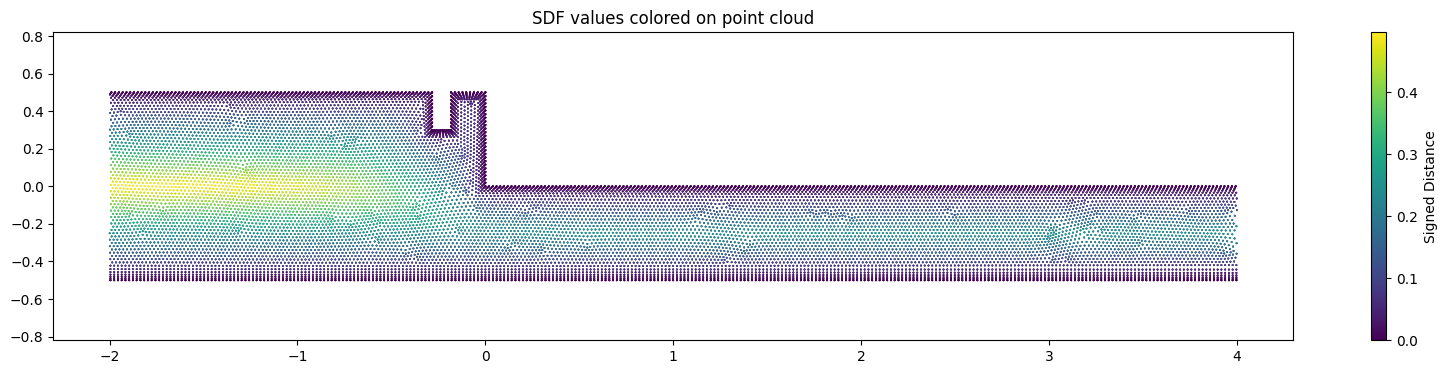

In [17]:
var = input_feat
coord = input_pos
# Visualize
plt.figure(figsize=(20, 4))
plt.scatter(coord[:, 0], coord[:, 1], c=var, s=0.1)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()

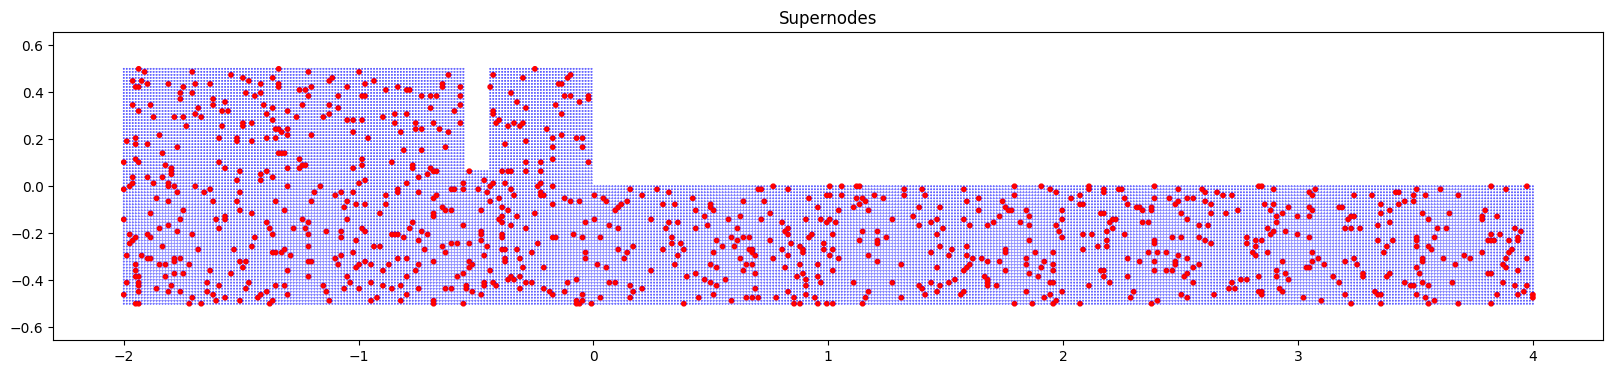

In [8]:
supernode_idxs = batch['supernode_idxs']
var = np.zeros_like(input_feat)+ 0.1
color = np.zeros_like(input_feat)
var[supernode_idxs] = 10
color[supernode_idxs] = 1
coord = input_pos
# Visualize
plt.figure(figsize=(20, 4))
plt.scatter(coord[:, 0], coord[:, 1], c=color, cmap='bwr', s=var)
# plt.colorbar(label="Supernodes")
plt.axis("equal")
plt.title("Supernodes")
plt.show()

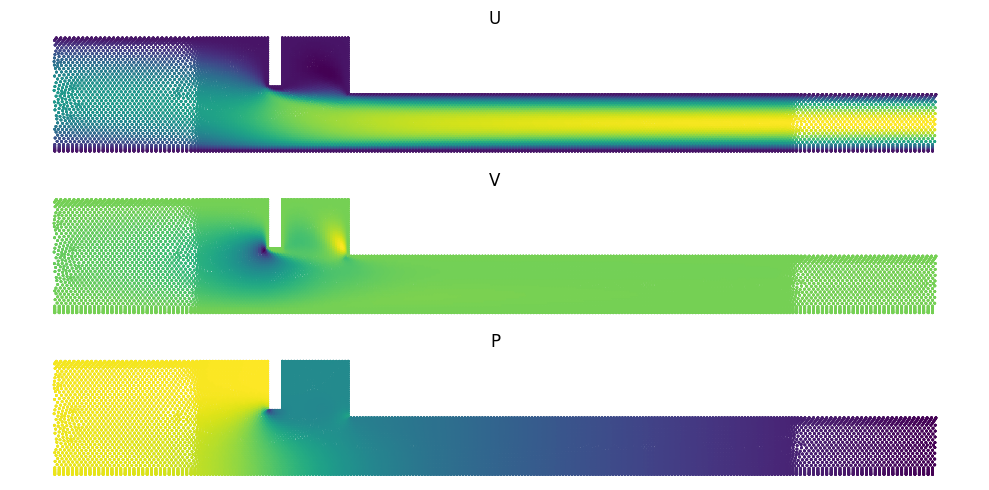

In [ ]:
coord = output_pos
var= target_feat
# Visualize
_, axes = plt.subplots(3, 1, figsize=(10, 5)) #, figsize=(10, 2)
axes[0].scatter(coord[:, 0], coord[:, 1], c=var[:,0], s=1)
axes[0].set_title("U")
axes[0].set_axis_off()
axes[1].scatter(coord[:, 0], coord[:, 1], c=var[:,1], s=1)
axes[1].set_title("V")
axes[1].set_axis_off()
axes[2].scatter(coord[:, 0], coord[:, 1], c=var[:,2], s=1)
axes[2].set_title("P")
axes[2].set_axis_off()
# plt.colorbar(ax=axes[2], orientation="horizontal")
plt.tight_layout()
# plt.colorbar()
# plt.title(test_batch["name"])
plt.show()


In [68]:
input_pos = test_hr_dataset.denormalize_pos(batch['input_pos'])
input_feat = test_hr_dataset.denormalize_sdf(batch['input_feat'])
output_pos = test_hr_dataset.denormalize_pos(batch['output_pos'][0])
target_feat = test_hr_dataset.denormalize_feat(batch['target_feat'])

print("Input position shape: \n", input_pos.shape)
print("Input position 1-5:\n", input_pos[:5], "\n")

print("Input feature shape: \n", input_feat.shape)
print("Input feature 1-5:\n", input_feat[:5], "\n")

print("Output position shape: \n", output_pos.shape)
print("Output position 1-5:\n", output_pos[:5], "\n")

print("Target feature shape: \n", target_feat.shape)
print("Target feature 1-5:\n", target_feat[:5], "\n")

Input position shape: 
 torch.Size([47202, 2])
Input position 1-5:
 tensor([[-0.0377,  0.4623],
        [-0.0546,  0.4623],
        [-0.0290,  0.4710],
        [-0.0467,  0.4710],
        [-0.0377,  0.4623]]) 

Input feature shape: 
 torch.Size([47202, 1])
Input feature 1-5:
 tensor([[0.0377],
        [0.0377],
        [0.0290],
        [0.0290],
        [0.0377]]) 

Output position shape: 
 torch.Size([47202, 2])
Output position 1-5:
 tensor([[-0.0377,  0.4623],
        [-0.0546,  0.4623],
        [-0.0290,  0.4710],
        [-0.0467,  0.4710],
        [-0.0377,  0.4623]]) 

Target feature shape: 
 torch.Size([47202, 3])
Target feature 1-5:
 tensor([[-4.5896e-04,  5.4762e-04,  1.0205e+01],
        [-1.3977e-03,  1.3934e-03,  1.0206e+01],
        [ 1.7881e-04, -1.5483e-04,  1.0205e+01],
        [-3.3009e-04,  5.0664e-04,  1.0206e+01],
        [-4.5896e-04,  5.4762e-04,  1.0205e+01]]) 

